# Machine Learning Final Project with Cora Dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from scapy.all import *
# from pcapng import FileScanner
import networkx as nx
from mpl_toolkits.mplot3d import axes3d
import os 

import torch
import torch.optim as optim
import torch.nn as nn

import seaborn as sns
from torch.nn import Sequential
import random
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
from torch.utils.data import Dataset ,DataLoader
from torchvision import transforms


from torch_geometric.nn import GCNConv
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from pycaret.datasets import get_data
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.utils import to_networkx

from torch_geometric.utils import to_networkx

import sklearn
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import metrics
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"set_seed_{seed}")
set_seed(42)

from tqdm.auto import trange,tqdm
from torch_geometric.datasets import Planetoid
from modules.metrics import *
%matplotlib inline
print("PyTorch has version {}".format(torch.__version__))

# from torch_geometric.datasets import CoraFull

set_seed_42
PyTorch has version 1.13.0


# EDA 

In [2]:
edgelist = pd.read_csv("./Cora/cora.cites", sep='\t', header=None, names=["target", "source"])
# edgelist["label"] = "cites"
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
content  = pd.read_csv("./Cora/cora.content",sep='\t',header=None,names =column_names)

In [3]:
#label이름이 들어있음, 
label_list = list(pd.get_dummies(content['subject']).columns)
label_list

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [4]:
Ordinary_encode = {i:idx for idx,i in enumerate(label_list)}
content["subject"] = content["subject"].map(Ordinary_encode)
content['subject']

31336      2
1061127    5
1106406    4
13195      4
37879      3
          ..
1128975    1
1128977    1
1128978    1
117328     0
24043      2
Name: subject, Length: 2708, dtype: int64

Ordinary Encoding을 진행 

In [5]:
edgelist #edge는 인용 여부 target이 source의 논문을 cite 

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


### edgelist: 참조된 논문 -> 참조한 논문   
### content : 논문의 id , 각 논문의 feature 정보(1433개의 단어) 논문의 장르(classification label)

---------------


## Show correlation 

In [6]:
corr = content.corr()

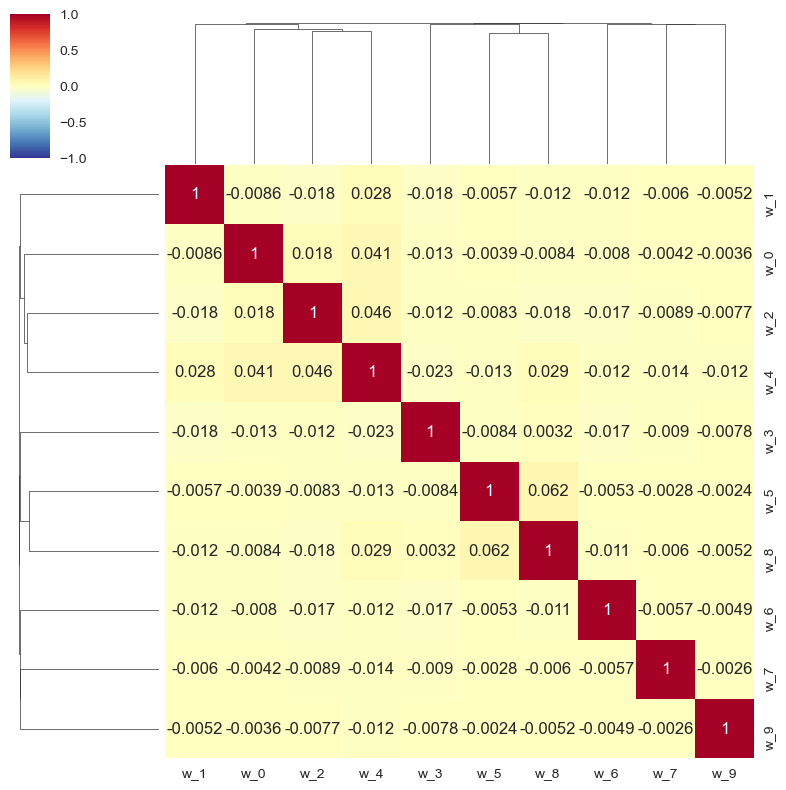

In [7]:

sns.clustermap(corr.iloc[:10,:10],annot =True,
              cmap = "RdYlBu_r",
              vmin = -1,vmax =1,figsize=(8,8))
plt.savefig("./jpeg/corr.jpeg",dpi=200)
plt.show()

## histogram

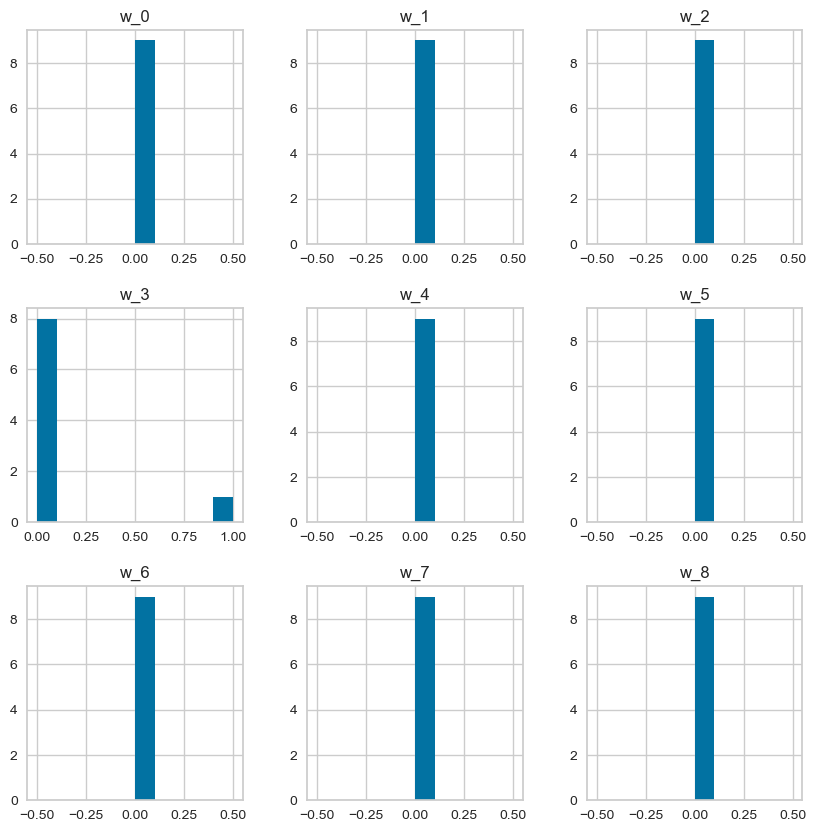

In [8]:
#간단하게 9개에 대한 hist gram을 출력해볼까요 
content.iloc[0:9,0:9].hist(figsize=(10,10))
plt.savefig("./jpeg/hist.jpeg",dpi=200)
plt.show()

In [9]:
train_,test = train_test_split(content,test_size=0.2,random_state=42,stratify=content["subject"])
train, valid = train_test_split(train_,test_size=0.2 ,random_state=42,stratify=train_["subject"])

In [10]:
train_x = train.drop(columns = 'subject',axis=1)
train_y = train["subject"]
valid_x = valid.drop(columns = 'subject',axis=1)
valid_y = valid["subject"]
test_x = test.drop(columns = 'subject',axis=1)
test_y = test["subject"]

train_x  = np.array(train_x,dtype = np.float32)
train_y  = np.array(train_y,dtype = np.float32)
valid_x  = np.array(valid_x,dtype = np.float32)
valid_y  = np.array(valid_y,dtype = np.float32)
test_x   = np.array(test_x, dtype = np.float32)
test_y   = np.array(test_y, dtype = np.float32)


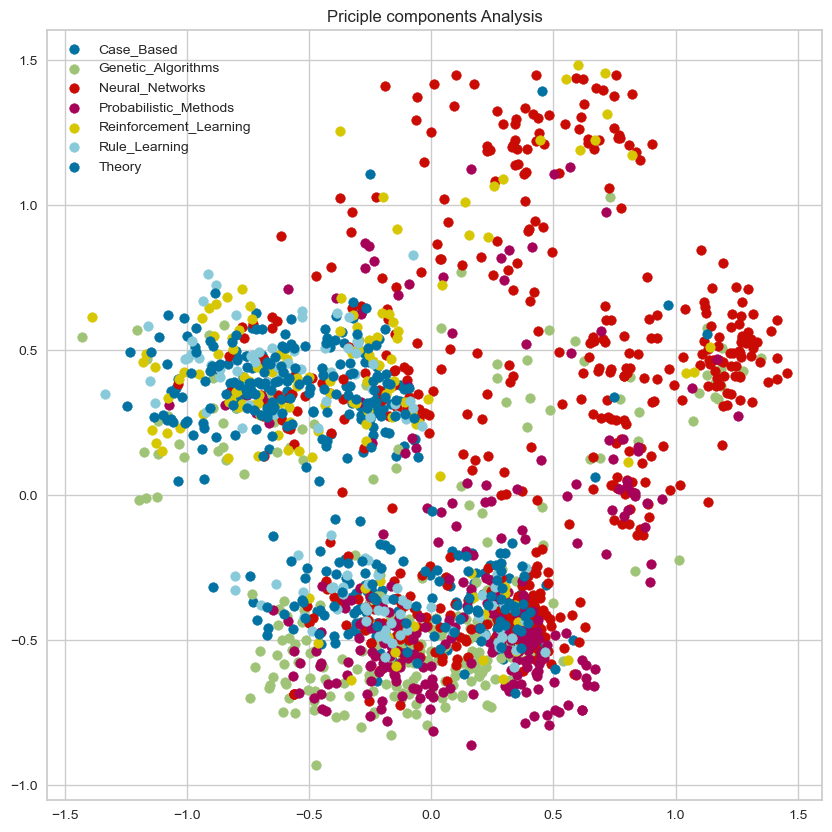

In [221]:
visualize_2d(train_x,train_y,label_list,save = True,mode ="pca")

In [ ]:
def tsne(data,label,label_list,save=True):
    tsne = TSNE(n_components=2) # 2 차원으로 축소 
    components = tsne.fit_transform(data) #data에 대해서 transform 진행 

    plt.figure(figsize=(10,10))

    x = [[],[],[],[],[],[],[]]
    y = [[],[],[],[],[],[],[]]
    for idx,i in enumerate(label):
        x[int(i)].append(components[idx][0])
        y[int(i)].append(components[idx][1])

    for i in range(7):
        plt.scatter(x[i],y[i],label = label_list[i])
    plt.title(f"Priciple components Analysis")
    plt.legend()
    plt.show()

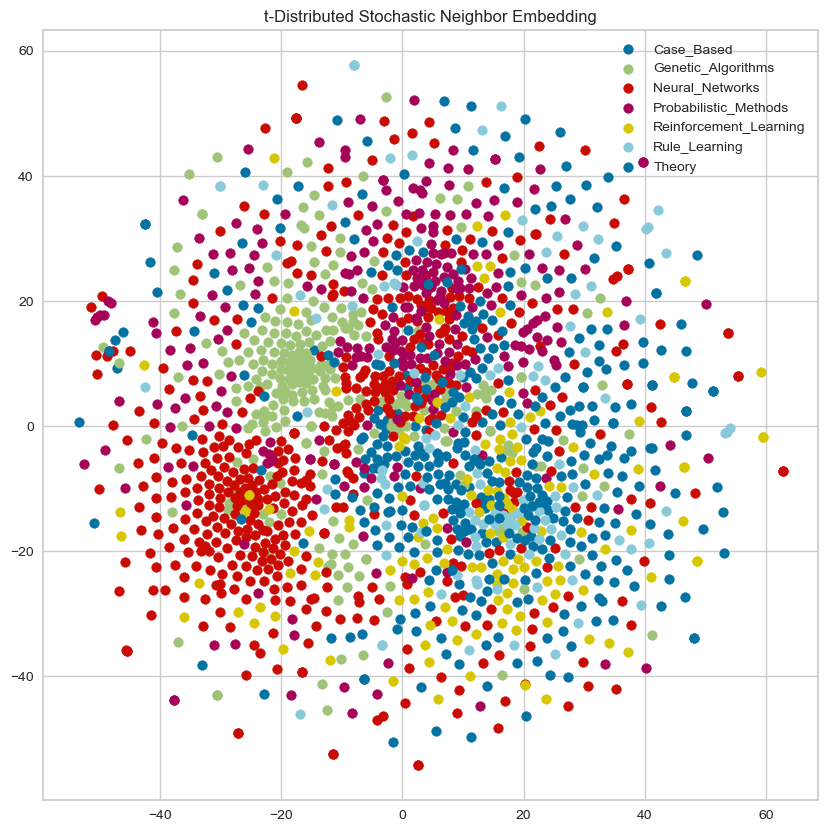

In [223]:
visualize_2d(train_x,train_y,label_list)

<Figure size 1500x1500 with 0 Axes>

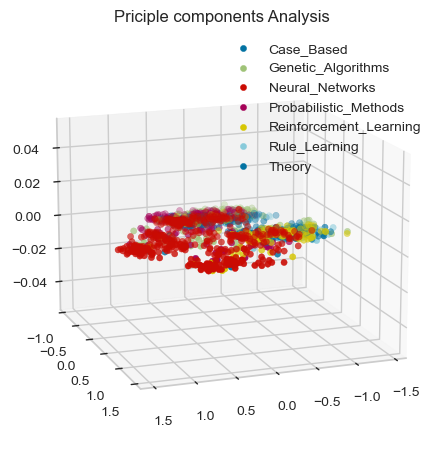

In [224]:
visualize_3d(train_x,train_y,label_list,save = True,mode ='pca')

<Figure size 1500x1500 with 0 Axes>

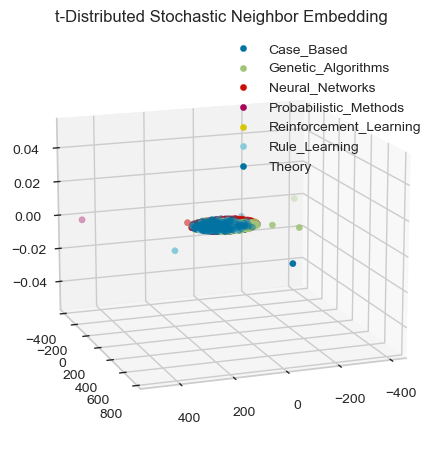

In [225]:
visualize_3d(train_x,train_y,label_list,save = True)

In [14]:
from pycaret.regression import *
setup_clf = setup(data = train_,target='subject',train_size=0.7,
                  # numeric_features = ["Duration","Src Pt","Dst Pt",],
                  # Remove Perfect Collinearity=True
                  use_gpu = True,
                  remove_perfect_collinearity=True,
                 session_id=777)

,Description,Value
0,session_id,777
1,Target,subject
2,Original Data,"(2166, 1434)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,1433
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1516, 1430)"


In [27]:
#5가지 좋은 모델을 select
best_model = compare_models(n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.0401,1.9999,1.4113,0.3961,0.4597,0.3574,10.6200
rf,Random Forest Regressor,0.9530,2.0253,1.4207,0.3884,0.4619,0.2954,1.6690
gbr,Gradient Boosting Regressor,1.1008,2.1055,1.4489,0.3641,0.4739,0.3726,1.9570
lightgbm,Light Gradient Boosting Machine,1.0736,2.1110,1.4504,0.3618,0.4677,0.3732,0.2250
br,Bayesian Ridge,1.1225,2.1584,1.4664,0.3489,0.4784,0.4006,1.5280
ada,AdaBoost Regressor,1.4220,2.9969,1.7295,0.0935,0.5562,0.5387,0.7450
omp,Orthogonal Matching Pursuit,1.3008,3.0547,1.7444,0.0762,0.5179,0.4963,0.0500
knn,K Neighbors Regressor,1.3626,3.0770,1.7506,0.0730,0.5488,0.4522,0.6830
par,Passive Aggressive Regressor,1.3855,3.0799,1.7518,0.0652,0.5487,0.5754,0.2670
et,Extra Trees Regressor,1.0467,3.1660,1.7766,0.0405,0.5499,0.3403,2.0590


# 가장 좋은 모델은 catboost, rf, gbr ,lightbgm, br이 top 5인 것으로 보임

In [28]:
best_model # 가장 좋은 모델이 저장되어 있음 

 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=777, verbose=0, warm_start=False),
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None,

In [137]:
#first test
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,99.2094,464055.3395,681.2161,-141103.3860,1.3908,18.8052
1,32.3693,20364.5963,142.7046,-7512.1520,1.4821,20.6391
2,227.3199,3674129.7279,1916.8020,-1174809.3027,1.4250,158.7029
3,17.6127,24608.6654,156.8715,-7489.4959,1.1214,5.4986
4,70.5613,226775.2546,476.2093,-74857.4173,1.4352,28.6012
5,220.7726,1001021.7773,1000.5108,-300049.6901,1.8093,96.2378
6,194.3764,1077602.9024,1038.0765,-298669.4565,1.7576,44.7595
7,935.9814,95170966.4363,9755.5608,-24294593.7796,1.5969,484.0219
8,83.2351,321447.2447,566.9632,-92435.8600,1.5197,86.1038


In [138]:
tune_lr = tune_model(lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.6037,26.0271,5.1017,-6.9140,0.8011,1.6088
1,3.8157,25.2108,5.0210,-8.3011,0.9191,1.6073
2,4.4435,36.0549,6.0046,-10.5286,0.8904,1.8288
3,4.4379,34.8939,5.9071,-9.6212,0.9758,2.3111
4,3.9136,25.2184,5.0218,-7.3246,0.9457,1.5777
5,69.7936,175766.3843,419.2450,-52683.9926,1.4238,31.2700
6,4.1421,30.0098,5.4781,-7.3176,0.9135,1.5861
7,3.9408,25.8733,5.0866,-5.6048,0.9241,1.5635
8,3.9860,29.4545,5.4272,-7.4701,0.9037,2.1409


In [40]:
evaluate_model(tune_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9457,1.9537,1.3978,0.4059,0.4657,0.2717
1,0.8936,1.7589,1.3262,0.3511,0.4699,0.2711
2,0.8963,1.7734,1.3317,0.4330,0.4221,0.2707
3,0.9333,1.7483,1.3222,0.4678,0.4474,0.3614
4,0.9564,1.9790,1.4068,0.3467,0.4463,0.2988
5,0.9761,2.2314,1.4938,0.3312,0.4781,0.2843
6,0.9634,2.1491,1.4660,0.4044,0.4788,0.2476
7,1.0169,2.3682,1.5389,0.3955,0.5100,0.2999
8,1.0220,2.4303,1.5589,0.3011,0.4562,0.3365


In [33]:
tune_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2118,2.4683,1.5711,0.2495,0.5175,0.3672
1,1.1144,2.3105,1.5200,0.1476,0.5203,0.3734
2,1.1583,2.3524,1.5337,0.2478,0.4608,0.3863
3,1.2854,2.5630,1.6009,0.2199,0.5212,0.4729
4,1.1523,2.3016,1.5171,0.2402,0.4744,0.3833
5,1.1965,2.6226,1.6194,0.2139,0.5224,0.3864
6,1.3170,2.8561,1.6900,0.2084,0.5389,0.3866
7,1.3999,3.1550,1.7762,0.1946,0.5668,0.4215
8,1.2502,2.6292,1.6215,0.2439,0.4824,0.4384


In [49]:
tune_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=220, n_jobs=-1, oob_score=False,
                      random_state=777, verbose=0, warm_start=False)

In [50]:
evaluate_model(tune_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [51]:
svm = create_model('svm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2537,2.8418,1.6858,0.1359,0.5284,0.3415
1,1.0332,2.1536,1.4675,0.2055,0.4786,0.3110
2,1.2420,2.8331,1.6832,0.0941,0.4631,0.3609
3,1.2332,2.7049,1.6447,0.1767,0.5054,0.3740
4,1.1335,2.5223,1.5882,0.1674,0.4825,0.3191
5,1.2250,2.8571,1.6903,0.1436,0.5200,0.3497
6,1.3558,3.2071,1.7908,0.1111,0.5329,0.3574
7,1.4006,3.4485,1.8570,0.1197,0.5442,0.3691
8,1.2647,3.0232,1.7387,0.1306,0.5048,0.3926


In [52]:
tune_svm = tune_model(svm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2259,2.2164,1.4888,0.3261,0.5110,0.4429
1,1.0765,1.8897,1.3747,0.3028,0.4947,0.4205
2,1.1836,2.1294,1.4593,0.3191,0.4565,0.4452
3,1.2153,2.1828,1.4774,0.3356,0.5042,0.4715
4,1.1741,2.1564,1.4685,0.2882,0.4792,0.4376
5,1.2353,2.4244,1.5570,0.2733,0.5216,0.4470
6,1.2690,2.4575,1.5676,0.3189,0.5163,0.4206
7,1.3230,2.5655,1.6017,0.3451,0.5348,0.4508
8,1.3029,2.5960,1.6112,0.2535,0.5066,0.5277


In [53]:
tune_svm

SVR(C=5.157, cache_size=200, coef0=0.0, degree=3, epsilon=1.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=False, tol=0.001, verbose=False)

In [42]:
evaluate_model(tune_svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [43]:
dt = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0329,3.6513,1.9108,-0.1102,0.6037,0.3028
1,1.1513,3.5329,1.8796,-0.3034,0.5935,0.4097
2,1.0789,3.8816,1.9702,-0.2411,0.6242,0.3347
3,1.2303,4.3092,2.0759,-0.3117,0.6705,0.4695
4,0.8816,2.7368,1.6543,0.0966,0.4676,0.2752
5,1.2500,4.5789,2.1398,-0.3725,0.6683,0.4275
6,1.0464,3.2980,1.8160,0.0859,0.5686,0.3014
7,1.0927,4.2185,2.0539,-0.0769,0.6219,0.3640
8,1.0861,3.8411,1.9599,-0.1046,0.6170,0.3287


In [44]:
tune_dt = tune_model(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1087,2.4282,1.5583,0.2617,0.5105,0.3403
1,1.0709,2.3749,1.5411,0.1238,0.5263,0.3460
2,1.0795,2.3847,1.5443,0.2375,0.4736,0.3518
3,1.2342,2.5939,1.6106,0.2104,0.5342,0.4491
4,1.0759,2.2709,1.5069,0.2504,0.4608,0.3594
5,1.1144,2.5641,1.6013,0.2314,0.5162,0.3520
6,1.2548,2.8437,1.6863,0.2118,0.5403,0.3632
7,1.2871,3.1285,1.7687,0.2014,0.5718,0.3866
8,1.1886,2.7572,1.6605,0.2071,0.4956,0.4258


In [45]:
evaluate_model(tune_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [46]:
# xg = create_model("xgboost")#xgboost는 gpu가 안됨 
gb = create_model("gbr")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1070,2.0667,1.4376,0.3716,0.4910,0.3549
1,1.0188,1.8639,1.3653,0.3123,0.4830,0.3476
2,1.0268,1.8021,1.3424,0.4238,0.4231,0.3677
3,1.0918,1.9231,1.3868,0.4146,0.4696,0.4139
4,1.0772,2.0875,1.4448,0.3109,0.4644,0.3616
5,1.0953,2.1766,1.4753,0.3476,0.4879,0.3427
6,1.1623,2.3882,1.5454,0.3381,0.4965,0.3271
7,1.2284,2.4734,1.5727,0.3686,0.5163,0.3801
8,1.1713,2.3772,1.5418,0.3164,0.4690,0.4411


In [47]:
tune_gb = tune_model(gb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0818,1.9401,1.3929,0.4101,0.4806,0.3505
1,0.9447,1.6020,1.2657,0.4090,0.4587,0.3486
2,1.0399,1.8556,1.3622,0.4067,0.4310,0.3682
3,1.0378,1.8782,1.3705,0.4283,0.4706,0.3822
4,1.0611,2.0196,1.4211,0.3333,0.4546,0.3650
5,1.0535,2.1459,1.4649,0.3568,0.4847,0.3317
6,1.1359,2.3153,1.5216,0.3583,0.4876,0.3240
7,1.1949,2.3665,1.5383,0.3959,0.5011,0.3673
8,1.1030,2.3940,1.5473,0.3116,0.4409,0.4061


In [54]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0304,1.8755,1.3695,0.4297,0.4741,0.3378
1,0.9769,1.7617,1.3273,0.3501,0.4728,0.3653
2,0.9936,1.6510,1.2849,0.4721,0.4143,0.3542
3,1.0017,1.7961,1.3402,0.4533,0.4527,0.3813
4,1.0229,1.9443,1.3944,0.3582,0.4407,0.3326
5,1.0767,2.2936,1.5145,0.3125,0.4915,0.3442
6,1.0559,2.1587,1.4693,0.4017,0.4674,0.3053
7,1.1435,2.3184,1.5226,0.4082,0.5048,0.3603
8,1.1159,2.3942,1.5473,0.3115,0.4587,0.4247


In [55]:
tune_catboost = tune_model(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9889,1.8088,1.3449,0.4500,0.4619,0.3291
1,0.9668,1.8210,1.3495,0.3282,0.4879,0.3517
2,0.9701,1.6393,1.2803,0.4758,0.4177,0.3506
3,1.0229,1.8901,1.3748,0.4247,0.4490,0.4059
4,1.0992,2.0620,1.4360,0.3193,0.4601,0.3763
5,1.0631,2.2086,1.4861,0.3380,0.4856,0.3654
6,1.0494,2.0713,1.4392,0.4259,0.4537,0.3182
7,1.1301,2.2681,1.5060,0.4210,0.4953,0.3576
8,1.1550,2.4171,1.5547,0.3049,0.4807,0.4369


In [113]:
tune_lr

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)

In [114]:
tune_svm

SVR(C=5.157, cache_size=200, coef0=0.0, degree=3, epsilon=1.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=False, tol=0.001, verbose=False)

In [115]:
tune_gb

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=6,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0005, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=280,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=777, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [116]:
tune_dt

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=5,
                      max_features=1.0, max_leaf_nodes=None,
                      min_impurity_decrease=0.0001, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=777, splitter='best')

In [117]:
tune_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=220, n_jobs=-1, oob_score=False,
                      random_state=777, verbose=0, warm_start=False)

In [118]:
tune_catboost

In [241]:
model_list = [tune_lr,tune_gb,tune_dt,tune_rf,tune_catboost,tune_svm]

In [242]:
predict = []
for i in model_list:
    predict.append(predict_model(i))
    # i.fit(train_x,train_y)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.8918,14.7305,3.8380,-3.5263,0.8188,1.3237


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.0448,1.9902,1.4107,0.3885,0.4749,0.3636


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.1466,2.7293,1.6520,0.1614,0.5336,0.3756


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.2290,2.7020,1.6438,0.1697,0.5360,0.4111


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.0139,1.9832,1.4082,0.3906,0.4661,0.3669


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Support Vector Regression,1.2137,2.2947,1.5148,0.2949,0.5116,0.4592


In [243]:
acc = []
model_name = []
for idx,i in enumerate(predict):
    acc.append(np.mean(np.round(i["Label"])==i["subject"]))
    model_name.append(type(model_list[idx]).__name__)
    print(f"{model_name[-1]}: acc  {acc[-1]}")

LinearRegression: acc  0.1276923076923077
GradientBoostingRegressor: acc  0.3723076923076923
DecisionTreeRegressor: acc  0.4169230769230769
RandomForestRegressor: acc  0.34307692307692306
CatBoostRegressor: acc  0.40923076923076923
SVR: acc  0.24769230769230768


In [244]:
import seaborn as sns

result_df = pd.DataFrame({'Model': model_name, 'Score': acc}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.127692
1,GradientBoostingRegressor,0.372308
2,DecisionTreeRegressor,0.416923
3,RandomForestRegressor,0.343077
4,CatBoostRegressor,0.409231
5,SVR,0.247692


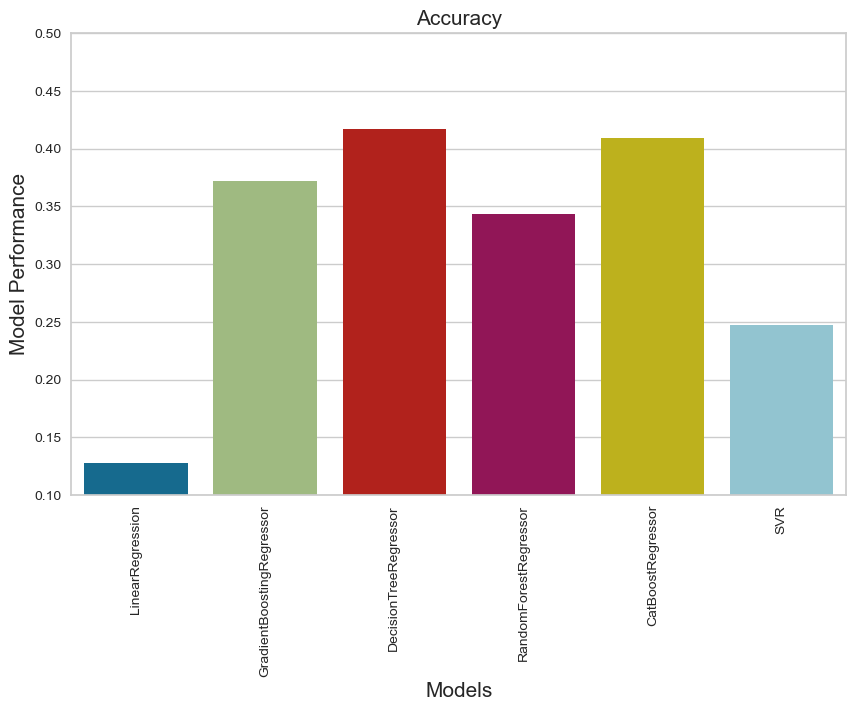

In [247]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.1, 0.5)
plt.title('Accuracy', fontsize=15)
plt.show()

In [234]:
model_list.pop(0)
model_list.pop(-1)

SVR(C=5.157, cache_size=200, coef0=0.0, degree=3, epsilon=1.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=False, tol=0.001, verbose=False)

In [235]:
#제일 성능이 안좋았던 Linear Regression은 제외
model_list

[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.05, loss='ls', max_depth=6,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0005, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=280,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=777, subsample=0.75, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=5,
                       max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fra

In [237]:
blended = blend_models(estimator_list = model_list, fold = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0483,1.9257,1.3877,0.3595,0.4876,0.3434
1,1.0600,1.9181,1.3850,0.4032,0.4565,0.3737
2,1.0459,2.0341,1.4262,0.3646,0.4649,0.3362
3,1.1813,2.4448,1.5636,0.3500,0.5154,0.3507
4,1.1109,2.1855,1.4783,0.3598,0.4617,0.4034
Mean,1.0893,2.1016,1.4482,0.3674,0.4772,0.3615
Std,0.0517,0.1970,0.0669,0.0185,0.0219,0.0245


In [248]:
pred_holdout = predict_model(blended)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1.0689,2.1391,1.4626,0.3427,0.4864,0.3591


In [249]:
print("ensenble_acc = {}".format(np.mean(np.round(pred_holdout["Label"])==pred_holdout["subject"])))

ensenble_acc = 0.38153846153846155


In [251]:
#제일 좋았던 모델들로 다시 blend
best_blended = blend_models(estimator_list = best_model, fold = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9918,1.7629,1.3277,0.4136,0.4686,0.3274
1,1.0061,1.8015,1.3422,0.4395,0.4467,0.3548
2,1.0028,1.9445,1.3945,0.3925,0.4569,0.3143
3,1.0811,2.1748,1.4747,0.4218,0.4887,0.3174
4,1.0718,2.1370,1.4618,0.3741,0.4491,0.3960
Mean,1.0307,1.9642,1.4002,0.4083,0.4620,0.3420
Std,0.0378,0.1683,0.0600,0.0228,0.0154,0.0305


In [252]:
best_pred_holdout = predict_model(best_blended)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1.0108,1.9861,1.4093,0.3897,0.4713,0.3379


In [255]:
final_model = finalize_model(best_blended)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x000001559BF845E0>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                 

In [256]:
save_model(final_model, './model/automl_save')


INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x0000015597A777F0>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_sample

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='subject',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy...
                                                             reg_lambda=0.0,
                                                             silent='warn',
                                                             subsample=1.0,
                                                             subsample_for_bin=20000

In [ ]:
final_model = load_model('./model/automl_save')

In [257]:
predictions = predict_model(final_model, data = test)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x0000015597A777F0>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.9596,1.7499,1.3228,0.4709,0.4267,0.3236


In [259]:
np.mean(np.round(predictions["Label"])==predictions["subject"])

0.4354243542435424

In [339]:
#output이 float이므로 정수형으로 형변환 
automl_predict = np.clip(np.round(predictions["Label"]),0,7)
automl_label = np.array(predictions["subject"])

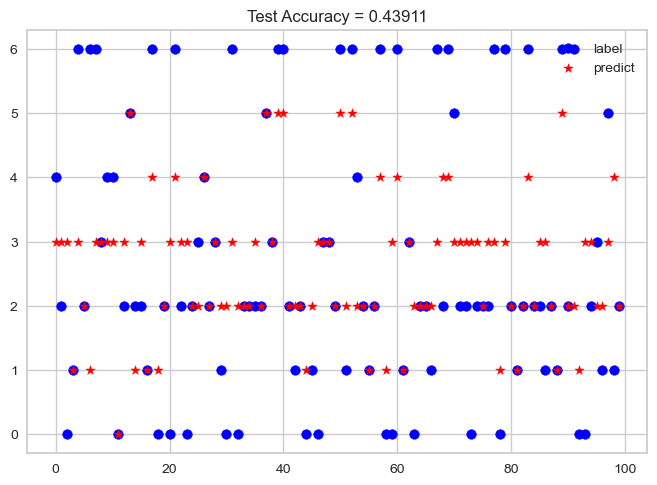

In [340]:
plt.scatter(np.arange(100),automl_label[:100],color = 'blue',label = "label")
plt.scatter(np.arange(100),automl_predict[:100],color = "red",marker='*',label = "predict")
plt.legend()
plt.title("Test Accuracy = {:.5f}".format(np.mean((automl_predict==automl_label))))
plt.show()

In [341]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay

In [342]:
cm = confusion_matrix(automl_predict,automl_label)
cm

array([[ 9,  1,  0,  0,  0,  0,  0],
       [20, 45,  4,  1,  1,  0,  1],
       [19, 31, 95, 16,  6,  5,  6],
       [10,  5, 60, 60, 17, 13, 19],
       [ 2,  2,  5,  7, 18,  8, 25],
       [ 0,  0,  0,  1,  1,  9, 17],
       [ 0,  0,  0,  0,  0,  1,  2]], dtype=int64)

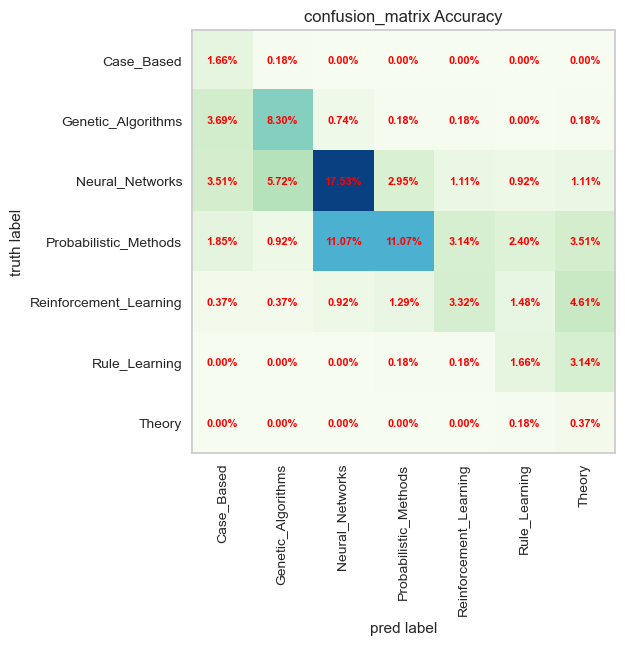

In [346]:
cm = cm/np.sum(cm)
plt.imshow(cm, cmap='GnBu')         

for (i,j),z in np.ndenumerate(cm):
    plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='red', fontsize=8, fontweight='bold')
    plt.title('confusion_matrix Accuracy')
    plt.xticks(np.arange(0, 7),label_list, rotation = 90)
    plt.yticks(np.arange(0, 7),label_list )
    plt.xlabel("pred label")
    plt.ylabel("truth label")

plt.grid(False)    
plt.show()

In [ ]:
import xgboost 